In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('final_data_in_ML.csv',index_col='Standardized_Date',parse_dates=True)
data

,STANDARDIZED_TIME,RAW WATER FLOW IN ML,CLEAR WATER SUMP LEVEL IN Meter,CLEAR WATER PUMPING FLOW ML,TREATED WATER PRODUCTION IN ML,REMARKS,remarks category
Standardized_Date,,,,,,,
2021-12-01,00:00:00,3.52301,2.10,2.70209,3.40957,No remarks,No remarks
2021-12-01,01:00:00,3.51043,2.84,2.77743,3.39739,No remarks,No remarks
2021-12-01,02:00:00,3.49087,3.12,2.79467,3.37846,No remarks,No remarks
2021-12-01,03:00:00,3.50543,3.44,2.79543,3.39256,No remarks,No remarks
2021-12-01,04:00:00,3.51556,3.72,2.79826,3.40236,No remarks,No remarks
...,...,...,...,...,...,...,...
2024-08-28,19:00:00,3.13486,3.46,2.87175,3.03392,No remarks,No remarks
2024-08-28,20:00:00,3.17401,3.63,2.85830,3.07181,No remarks,No remarks
2024-08-28,21:00:00,3.13113,3.64,2.87098,3.03031,No remarks,No remarks


In [3]:
target = 'CLEAR WATER PUMPING FLOW ML'

In [4]:
# Create lag features for the target and other relevant variables
data['PUMPING_FLOW_LAG_1'] = data[target].shift(1)
data['PUMPING_FLOW_LAG_2'] = data[target].shift(2)
data['RAW_WATER_LAG_1'] = data['RAW WATER FLOW IN ML'].shift(1)
data['SUMP_LEVEL_LAG_1'] = data['CLEAR WATER SUMP LEVEL IN Meter'].shift(1)

# Create rolling mean features (e.g., 7-day rolling mean)
data['PUMPING_FLOW_ROLLING_MEAN_7'] = data[target].rolling(window=7).mean()

# Drop rows with NaN values caused by shifting and rolling
data.dropna(inplace=True)


In [5]:
# Define the cutoff for train-test split
train_size = int(len(data) * 0.8)

# Split into train and test sets
X = data[['PUMPING_FLOW_LAG_1', 'PUMPING_FLOW_LAG_2', 'RAW_WATER_LAG_1', 
          'SUMP_LEVEL_LAG_1', 'PUMPING_FLOW_ROLLING_MEAN_7']]
y = data[target]

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [6]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Initialize the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)


In [7]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f'RMSE: {rmse}')


RMSE: 0.5223366933805227


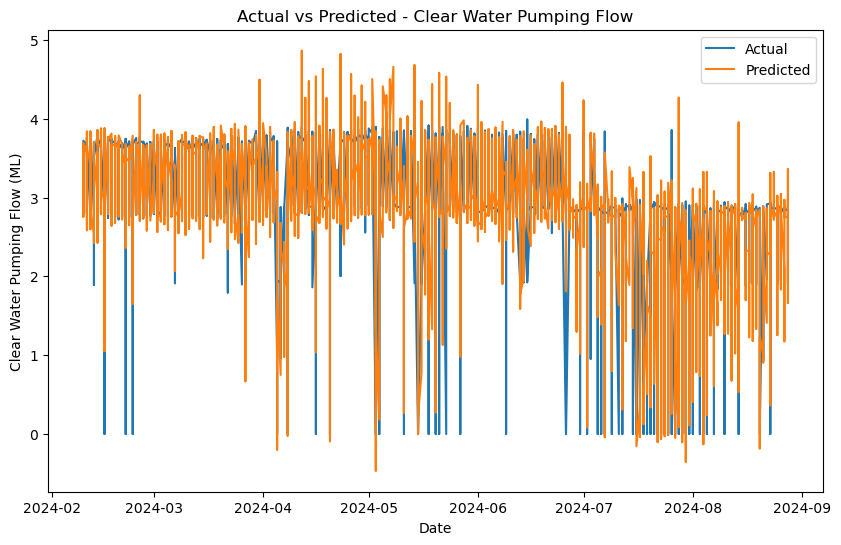

In [8]:
import matplotlib.pyplot as plt

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(data.index[train_size:], y_test, label='Actual')
plt.plot(data.index[train_size:], y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Clear Water Pumping Flow (ML)')
plt.title('Actual vs Predicted - Clear Water Pumping Flow')
plt.legend()
plt.show()


In [9]:
# Print the predicted values
print("Predicted values:")
y_pred


Predicted values:


array([2.8106918, 2.8452537, 2.7552795, ..., 2.7824113, 2.849317 ,
       2.9687998], dtype=float32)

In [10]:
# Create a DataFrame to show the actual and predicted values side by side
predictions_df = pd.DataFrame({
    'Date': data.index[train_size:],   # Dates from the test set
    'Actual': y_test.values,           # Actual values
    'Predicted': y_pred                # Predicted values
})

# Set the Date as the index
predictions_df.set_index('Date', inplace=True)

# Print the DataFrame with actual and predicted values
predictions_df


,Actual,Predicted
Date,,
2024-02-10,2.80677,2.810692
2024-02-10,2.78697,2.845254
2024-02-10,2.81131,2.755280
2024-02-10,2.83912,3.219053
2024-02-10,2.81035,2.799364
...,...,...
2024-08-28,2.87175,2.873004
2024-08-28,2.85830,2.781381
2024-08-28,2.87098,2.782411
